*Copyright (C) 2022 Intel Corporation*<br>
*SPDX-License-Identifier: BSD-3-Clause*<br>
*See: https://spdx.org/licenses/*

---

# Walk through Lava

Lava is an open-source software library dedicated to the development of algorithms for neuromorphic computation. To that end, Lava provides an easy-to-use Python interface for creating the bits and pieces required for such a neuromorphic algorithm. For easy development, Lava allows to run and test all neuromorphic algorithms on standard von-Neumann hardware like CPU, before they can be deployed on neuromorphic processors such as the Intel Loihi 1/2 processor to leverage their speed and power advantages. Furthermore, Lava is designed to be extensible to custom implementations of neuromorphic behavior and to support new hardware backends.

Lava can fundamentally be used at two different levels: Either by using existing resources which can be used to create complex algorithms while requiring almost no deep neuromorphic knowledge. Or, for custom behavior, Lava can be easily extended with new behavior defined in Python and C.

![lava_overview.png](https://raw.githubusercontent.com/lava-nc/lava-docs/dev/walk-through-tutorial/_static/images/tutorial00/lava_overview.png)

This tutorial gives an high-level overview over the key components of Lava. For illustration, we will use a simple working example: a feed-forward multi-layer LIF network executed locally on CPU.
In the first section of the tutorial, we use the internal resources of Lava to construct such a network and in the second section, we demonstrate how to extend Lava with a custom process using the example of an input generator.

In addition to the core Lava library described in the present tutorial, the following tutorials guide you to use high level functionalities:
- [lava-dl](https://github.com/lava-nc/lava-dl) for deep learning applications
- [lava-optimization](https://github.com/lava-nc/lava-optimization) for constraint optimization
- [lava-dnf](https://github.com/lava-nc/lava-dnf) for Dynamic Neural Fields

## 1. Usage of the Process Library

In this section, we will use a simple 2-layered feed-forward network of LIF neurons executed on CPU as canonical example. 

The fundamental building block in the Lava architecture is the `Process`. A `Process` describes a functional group, such as a population of `LIF` neurons, which runs asynchronously and parallel and communicates via `Channels`. A `Process` can take different forms and does not necessarily be a population of neurons, for example it could be a complete network, program code or the interface to a sensor (see figure below).

![process_overview.png](https://raw.githubusercontent.com/lava-nc/lava-docs/dev/walk-through-tutorial/_static/images/tutorial00/proc_overview.png)

For convenience, Lava provides a growing Process Library in which many commonly used `Processes` are publicly available.
In the first section of this tutorial, we will use the `Processes` of the Process Library to create and execute a multi-layer LIF network. Take a look at the [documentation](https://lava-nc.org) to find out what other `Processes` are implemented in the Process Library.

Let's start by importing the classes `LIF` and `Dense` and take a brief look at the docstring.

In [1]:
from lava.proc.lif.process import LIF
from lava.proc.dense.process import Dense

LIF?

Init signature: LIF(*args, **kwargs)
Docstring:     
Leaky-Integrate-and-Fire (LIF) neural Process.

LIF dynamics abstracts to:
u[t] = u[t-1] * (1-du) + a_in         # neuron current
v[t] = v[t-1] * (1-dv) + u[t] + bias  # neuron voltage
s_out = v[t] > vth                    # spike if threshold is exceeded
v[t] = 0                              # reset at spike

Parameters
----------
shape : tuple(int)
    Number and topology of LIF neurons.
u : float, list, numpy.ndarray, optional
    Initial value of the neurons' current.
v : float, list, numpy.ndarray, optional
    Initial value of the neurons' voltage (membrane potential).
du : float, optional
    Inverse of decay time-constant for current decay. Currently, only a
    single decay can be set for the entire population of neurons.
dv : float, optional
    Inverse of decay time-constant for voltage decay. Currently, only a
    single decay can be set for the entire population of neurons.
bias_mant : float, list, numpy.ndarray, optiona

The docstring gives insights about the parameters and internal dynamics of the `LIF` neuron. `Dense` is used to connect to a neuron population in an all-to-all fashion, often implemented as a matrix-vector product.

In the next box, we will create the `Processes` we need to implement a multi-layer LIF (LIF-Dense-LIF) network.

In [2]:
import numpy as np

# Create processes
lif1 = LIF(shape=(3, ),                         # Number and topological layout of units in the process
           vth=10.,                             # Membrane threshold
           dv=0.1,                              # Inverse membrane time-constant
           du=0.1,                              # Inverse synaptic time-constant
           bias_mant=(1.1, 1.2, 1.3),           # Bias added to the membrane voltage in every timestep
           name="lif1")

dense = Dense(weights=np.random.rand(2, 3),     # Initial value of the weights, chosen randomly
              name='dense')

lif2 = LIF(shape=(2, ),                         # Number and topological layout of units in the process
           vth=10.,                             # Membrane threshold
           dv=0.1,                              # Inverse membrane time-constant
           du=0.1,                              # Inverse synaptic time-constant
           bias_mant=0.,                        # Bias added to the membrane voltage in every timestep
           name='lif2')

As you can see, we can either specify parameters with scalars, then all units share the same initial value for this parameter, or with a tuple (or list, or numpy array) to set the parameter individually per unit.


### Processes

Let's investigate the objects we just created. As mentioned before, both, `LIF` and `Dense` are examples of `Processes`, the main building block in Lava.

A `Process` holds three key components (see figure below):

- Input ports
- Variables
- Output ports

![process.png](https://raw.githubusercontent.com/lava-nc/lava-docs/dev/walk-through-tutorial/_static/images/tutorial00/proc.png)

The `Vars` are used to store internal states of the `Process` while the `Ports` are used to define the connectivity between the `Processes`. Note that a `Process` only defines the `Vars` and `Ports` but not the behavior. This is done separately in a `ProcessModel`. To separate the interface from the behavioral implementation has the advantage that we can define the behavior of a `Process` for multiple hardware backends using multiple `ProcessModels` without changing the interface. We will get into more detail about `ProcessModels` in the second part of this tutorial.

### Ports and connections

Let's take a look at the `Ports` of the `LIF` and `Dense` processes we just created.  The output `Port` of the `LIF` neuron is called `s_out`, which stands for 'spiking' output. The input `Port` is called `a_in` which stands for 'activation' input.

In [3]:
lif1.out_ports.member_names

['s_out']

For example, we can see the size of the `Port` which is in particular important because `Ports` can only connect if their shape matches.

In [4]:
assert(lif1.s_out.size == dense.s_in.size)

Similarly we can investigate the input port of the second `LIF` population.

In [5]:
lif2.in_ports.member_names

['a_in']

In [6]:
assert(dense.a_out.size == lif2.a_in.size)

Now that we know about the input and output `Ports` of the `LIF` and `Dense` `Processes`, we can `connect` the network to complete the LIF-Dense-LIF structure.

![process_comm.png](https://raw.githubusercontent.com/lava-nc/lava-docs/dev/walk-through-tutorial/_static/images/tutorial00/procs.png)

As can be seen in the figure above, by `connecting` two processes, a `Channel` between them is created which means that messages between those two `Processes` can be exchanged.

In [7]:
# Connect the OutPort of lif1 to the InPort of dense
lif1.s_out.connect(dense.s_in)

# Connect the OutPort of dense to the InPort of lif2
dense.a_out.connect(lif2.a_in)

### Variables

Similar to the `Ports`, we can investigate the `Vars` of a `Process`.

In [8]:
lif1.vars.member_names

['bias_exp', 'bias_mant', 'du', 'dv', 'u', 'v', 'vth']

`Vars` are also accessible as member variables. We can print details of a specific `Var` to see the shape, initial value and current value. The `shareable` attribute controls whether a `Var` can be manipulated via remote memory access. Learn more about about this topic in the [remote memory access tutorial](https://github.com/lava-nc/lava/blob/main/tutorials/in_depth/tutorial07_remote_memory_access.ipynb).

In [9]:
lif1.v

Variable: v
    shape: (3,)
    init: 0
    shareable: True
    value: 0

We can take a look at the random weights of `Dense` by calling the `get` function.

In [10]:
dense.weights.get()

array([[0.48667088, 0.24619592, 0.89903799],
       [0.96371252, 0.58821522, 0.37490556]])

<div class="alert alert-block alert-info">
<b>Note: </b> There is also a `set` function available to change the value of a `Var` after the network was executed.
</div>

### Record internal Vars over time

In order to record the evolution of the internal `Vars` over time, we need a `Monitor`.
For this example, we want to record the membrane potential of both `LIF` Processes, hence we need two `Monitors`.

In [11]:
from lava.proc.monitor.process import Monitor

monitor_lif1 = Monitor()
monitor_lif2 = Monitor()

We can define the `Var` that a `Monitor` should record, as well as the recording duration, using the `probe` function.

In [12]:
num_steps = 100

monitor_lif1.probe(lif1.v, num_steps)
monitor_lif2.probe(lif2.v, num_steps)

<div class="alert alert-block alert-info">
<b>Note: </b> Currently, the `Monitor` can only record a single `Var` per `Process` and supports only CPU. This functionality will be extended in future releases.
</div>

### Execution

Now, that we finished to set up the network and recording `Processes`, we can execute the network by simply calling the `run` function of one of the `Processes`.

The `run` function requires two parameters, a `RunCondition` and a `RunConfig`. The `RunCondition` defines *how* the network runs (i.e. for how long) while the `RunConfig` defines on which hardware backend the `Processes` should be mapped and executed.

#### Run Conditions

Let's investigate the different possibilities for `RunConditions`. One option is `RunContinuous` which executes the network continuously and non-blocking until `pause` or `stop` is called.

In [13]:
from lava.magma.core.run_conditions import RunContinuous
run_condition = RunContinuous()

The second option is `RunSteps`, which allows you to define an exact amount of time steps the network should run.

In [14]:
from lava.magma.core.run_conditions import RunSteps, RunContinuous

run_condition = RunSteps(num_steps=num_steps)

For this example. we will use `RunSteps` and let the network run exactly `num_steps` time steps.

#### RunConfigs

Next, we need to provide a `RunConfig`. As mentioned above, The `RunConfig` defines on which hardware backend the network is executed.

For example, we could run the network on the Loihi1 processor using the `Loihi1HwCfg`, on Loihi2 using the `Loihi2HwCfg`, or on CPU using the `Loihi1SimCfg`. The compiler and runtime then automatically select the correct `ProcessModels` such that the `RunConfig` can be fulfilled.

For this section of the tutorial, we will run our network on CPU, later we will show how to run the same network on the Loihi2 processor.

In [15]:
from lava.magma.core.run_configs import Loihi1SimCfg

run_cfg = Loihi1SimCfg()

#### Execute

Finally, we can simply call the `run` function of the second `LIF` process and provide the `RunConfig` and `RunCondition`.

In [16]:
lif2.run(condition=run_condition, run_cfg=run_cfg)

### Retrieve recorded data

After the simulation has stopped, we can call `get_data` on the two monitors to retrieve the recorded membrane potentials.

In [17]:
data_lif1 = monitor_lif1.get_data()
data_lif2 = monitor_lif2.get_data()

Alternatively, we can also use the provided `plot` functionality of the `Monitor`, to plot the recorded data. As we can see, the bias of the first `LIF` population drives the membrane potential to the threshold which generates output spikes. Those output spikes are passed through the `Dense` layer as input to the second `LIF` population.

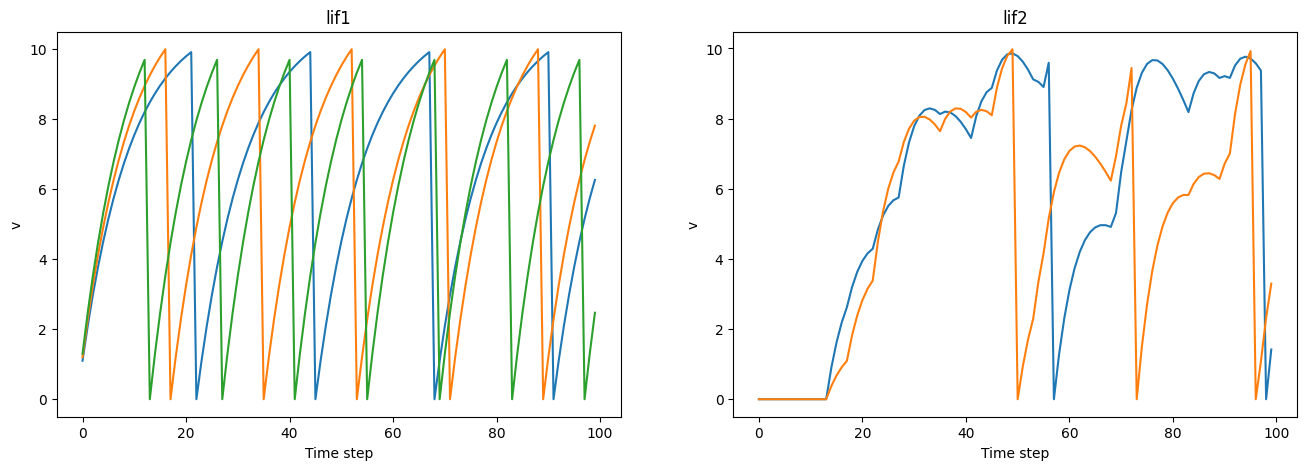

In [18]:
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

# Create a subplot for each monitor
fig = plt.figure(figsize=(16, 5))
ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122)

# Plot the recorded data
monitor_lif1.plot(ax0, lif1.v)
monitor_lif2.plot(ax1, lif2.v)

As a last step we can stop the runtime by calling the `stop` function. `Stop` will terminate the `Runtime` and all states will be lost.

In [19]:
lif2.stop()

### Summary

- There are many tools available in the Process Library to construct basic networks
- The fundamental building block in Lava is the `Process`
- Each `Process` consists of `Vars` and `Ports`
- A `Process` defines a common interface across hardware backends, but not the behavior
- The `ProcessModel` defines the behavior of a `Process` for a specific hardware backend
- `Vars` store internal states, `Ports` are used to implement communication channels between processes
- The `RunConfig` defines on which hardware backend the network runs 

### Learn more about
- [Processes](https://github.com/lava-nc/lava/blob/main/tutorials/in_depth/tutorial02_processes.ipynb) and [hierarchical Processes](https://github.com/lava-nc/lava/blob/main/tutorials/in_depth/tutorial06_hierarchical_processes.ipynb)
- [Possible connectivity patterns](https://github.com/lava-nc/lava/blob/main/tutorials/in_depth/tutorial05_connect_processes.ipynb)
- [Remote memory access](https://github.com/lava-nc/lava/blob/main/tutorials/in_depth/tutorial07_remote_memory_access.ipynb)
- [Execution](https://github.com/lava-nc/lava/blob/main/tutorials/in_depth/tutorial04_execution.ipynb)

## 2. Create a custom Process

In the previous section of this tutorial, we used `Processes` which were available in the Process Library. In many cases, this might be sufficient and the Process Library is constantly growing. Nevertheless, the Process Library can not cover all use-cases. Hence, Lava makes it very easy to create new `Processes`. In the following section, we want to show how to implement a custom `Process` and the corresponding behavior using a `ProcessModel`.

The example of the previous section implemented a bias driven LIF-Dense-LIF network. One crucial aspect which is missing this example, is the input/output interaction with sensors and actuators. Commonly used sensors would be Dynamic Vision Sensors or artificial cochleas, but for demonstration purposes we will implement a simple `SpikeGenerator`. The purpose of the `SpikeGenerator` is to output random spikes to drive the LIF-Dense-LIF network. 

Let's start by importing the necessary classes from Lava.

In [20]:
from lava.magma.core.process.process import AbstractProcess
from lava.magma.core.process.variable import Var
from lava.magma.core.process.ports.ports import OutPort

All `Processes` in Lava inherit from a common base class called `AbstractProcess`. Additionally, we need `Var` for storing the spike probability and `OutPort` to define the output connections for our `SpikeGenerator`.

In [21]:
class SpikeGenerator(AbstractProcess):
    """Spike generator process provides spikes to subsequent Processes.

    Parameters
    ----------
    shape: tuple
        defines the dimensionality of the generated spikes per timestep
    spike_prob: int
        spike probability in percent
    """
    def __init__(self, shape: tuple, spike_prob: int) -> None:        
        super().__init__()
        self.spike_prob = Var(shape=(1, ), init=spike_prob)
        self.s_out = OutPort(shape=shape)


The constructor of `Var` requires the shape of the data to be stored and some initial value. We use this functionality to store the spike data. Similarly, we define an `OutPort` for our `SpikeGenerator`. 

### Create a new ProcessModel 
As mentioned earlier, the `Process` only defines the interface but not the behavior of the `SpikeGenerator`. We will do that in a separate `ProcessModel` which has the advantage that we can define the behavior of a `Process` on different hardware backends without changing the interface (see figure below). More details about the different kinds of `ProcessModels` can be found in the dedicated in-depth tutorials ([here](https://github.com/lava-nc/lava/blob/main/tutorials/in_depth/tutorial03_process_models.ipynb) and [here](https://github.com/lava-nc/lava/blob/main/tutorials/in_depth/tutorial06_hierarchical_processes.ipynb)). Lava automatically selects the correct `ProcessModel` for each `Process` given the `RunConfig`.

![process_models.png](https://raw.githubusercontent.com/lava-nc/lava-docs/dev/walk-through-tutorial/_static/images/tutorial00/proc_models.png)

So, let's go ahead and define the behavior of the `SpikeGenerator` on a CPU in Python. Later in this tutorial we will show how to implement the same behavior on an embedded CPU in C and how to implement the behavior of a `LIF` process on a Loihi2 neuro-core.

We first import all necessary classes from Lava.

In [22]:
from lava.magma.core.model.py.model import PyLoihiProcessModel
from lava.magma.core.resources import CPU
from lava.magma.core.decorator import implements, requires
from lava.magma.core.sync.protocols.loihi_protocol import LoihiProtocol
from lava.magma.core.model.py.type import LavaPyType
from lava.magma.core.model.py.ports import PyOutPort

All `ProcessModels` defined to run on CPU are written in Python and inherit from the common class called `PyLoihiProcessModel`. Further, we use the decorators `requires` and `implements` to define which computational resources (i.e. CPU, GPU, Loihi1NeuroCore, Loihi2NeuroCore) are required to execute this `ProcessModel` and which `Process` it implements. Finally, we need to specify the types of `Vars` and `Ports` in our `SpikeGenerator` using `LavaPyType` and `PyOutPort`.



<div class="alert alert-block alert-info">
<b>Note: </b> It is important to mention that the `ProcessModel` needs to implement the exact same Vars and Ports of the parent process using the same class attribute names.
</div>

Additionally, we define that our `PySpikeGeneratorModel` follows the `LoihiProtocol`. The `LoihiProtocol` defines that the execution of a model follows a specific sequence of phases. For example, there is the *spiking phase* (`run_spk`) in which input spikes are received, internal `Vars` are updated and output spikes are sent. There are other phases such as the *learning phase* (`run_lrn`) in which online learning takes place, or the *post management phase* (`run_post_mgmt`) in which memory content is updated. As the `SpikeGenerator` basically just sends out spikes, the correct place to implement its behavior is the `run_spk` phase. 

To implement the behavior, we need to have access to the global simulation time. We can easily access the simulation time with `self.time_step` and use that to index the `spike_data` and send out the corresponding spikes through the `OutPort`.

In [23]:
@implements(proc=SpikeGenerator, protocol=LoihiProtocol)
@requires(CPU)
class PySpikeGeneratorModel(PyLoihiProcessModel):
    """Spike Generator process model."""
    spike_prob: int = LavaPyType(int, int)
    s_out: PyOutPort = LavaPyType(PyOutPort.VEC_DENSE, float)

    def run_spk(self) -> None:
        # Generate random spike data
        spike_data = np.random.choice([0, 1], p=[1 - self.spike_prob/100, self.spike_prob/100], size=self.s_out.shape[0])
        
        # Send spikes
        self.s_out.send(spike_data)

<div class="alert alert-block alert-info">
<b>Note: </b> For the `SpikeGenerator` we only needed an `OutPort` which provides the `send` function to send data. For the `InPort` the corresponding function to receive data is called `recv`.
</div>

Next, we want to redefine our network as in the example before with the exception that we turn off all biases.

In [24]:
# Create processes
lif1 = LIF(shape=(3, ),                         # Number of units in this process
           vth=10.,                             # Membrane threshold
           dv=0.1,                              # Inverse membrane time-constant
           du=0.1,                              # Inverse synaptic time-constant
           bias_mant=0.,                        # Bias added to the membrane voltage in every timestep
           name="lif1")

dense = Dense(weights=np.random.rand(2, 3),     # Initial value of the weights, chosen randomly
              name='dense')

lif2 = LIF(shape=(2, ),                         # Number of units in this process
           vth=10.,                             # Membrane threshold
           dv=0.1,                              # Inverse membrane time-constant
           du=0.1,                              # Inverse synaptic time-constant
           bias_mant=0.,                        # Bias added to the membrane voltage in every timestep
           name='lif2')

# Connect the OutPort of lif1 to the InPort of dense
lif1.s_out.connect(dense.s_in)

# Connect the OutPort of dense to the InPort of lif2
dense.a_out.connect(lif2.a_in)

# Create Monitors to record membrane potentials
monitor_lif1 = Monitor()
monitor_lif2 = Monitor()

# Probe membrane potentials from the two LIF populations
monitor_lif1.probe(lif1.v, num_steps)
monitor_lif2.probe(lif2.v, num_steps)

### Use the custom SpikeGenerator

We instantiate the `SpikeGenerator` as usual with the shape of the fist `LIF` population.

To define the connectivity between the `SpikeGenerator` and the first `LIF` population, we us another `Dense` Layer.
Now, we can connect its `OutPort` to the `InPort` of the `Dense` layer and the `OutPort` of the `Dense` layer to the `InPort` of the first `LIF` population.


In [25]:
# Instantiate SpikeGenerator
spike_gen = SpikeGenerator(shape=(lif1.a_in.shape[0], ), spike_prob=7)

# Instantiate Dense
dense_input = Dense(weights=np.eye(lif1.a_in.shape[0])) # one-to-one connectivity

# Connect spike_gen to dense_input
spike_gen.s_out.connect(dense_input.s_in)

# Connect dense_input to LIF1 population
dense_input.a_out.connect(lif1.a_in)

### Execute and plot

Now that our network is complete, we can execute it the same way as before using the `RunCondition` and `RunConfig` we created in the previous example.

In [26]:
lif2.run(condition=run_condition, run_cfg=run_cfg)

And now, we can retrieve the recorded data and plot the membrane potentials of the two `LIF` populations.

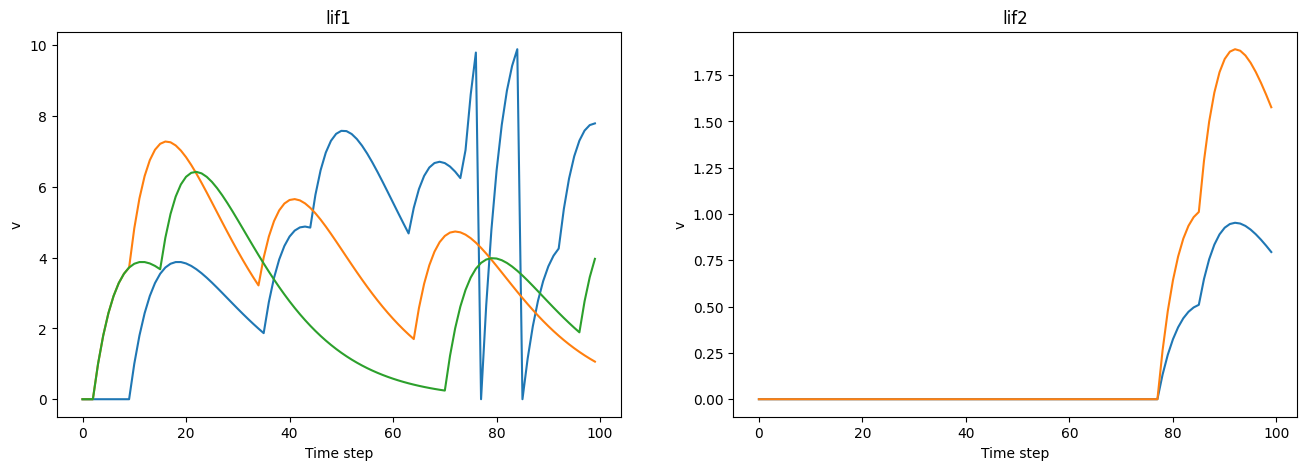

In [27]:
# Create a subplot for each monitor
fig = plt.figure(figsize=(16, 5))
ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122)

# Plot the recorded data
monitor_lif1.plot(ax0, lif1.v)
monitor_lif2.plot(ax1, lif2.v)

As we can see, the spikes provided by the `SpikeGenerator` are sucessfully sent to the first `LIF` population. which in turn sends its output spikes to the second `LIF` population.

In [28]:
lif2.stop()

### Summary

- Define custom a `Process` by inheritance from `AbstractProcess`
- `Vars` are used to store internal data in the `Process`
- `Ports` are used to connect to other `Processes`
- The behavior of a `Process` is defined in a `ProcessModel`
- `ProcessModels` are aware of their hardware backend, they get selected automatically by the compiler/runtime
- `PyProcessModels` run on CPU
- Number and names of `Vars` and `Ports` of a `ProcessModel` must match those of the `Process` it implements

### Learn more about
- [ProcessModels](https://github.com/lava-nc/lava/blob/main/tutorials/in_depth/tutorial03_process_models.ipynb)


### How to learn more?

If you want to find out more about Lava, have a look at the [Lava documentation](https://lava-nc.org/) or dive deeper with the [in-depth tutorials](https://github.com/lava-nc/lava/tree/main/tutorials/in_depth).

To receive regular updates on the latest developments and releases of the Lava Software Framework please subscribe to [our newsletter](http://eepurl.com/hJCyhb).